# Configure Phenotype Parameters

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running phenotype module.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for phenotype processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from microfilm.microplot import Microimage

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_micropanel,
    random_cmap,
    image_segmentation_annotations,
    convert_tuples_to_lists,
)
from lib.shared.file_utils import get_filename
from lib.shared.illumination_correction import apply_ic_field
from lib.phenotype.align_channels import align_phenotype_channels, visualize_phenotype_alignment
from lib.shared.align import apply_custom_offsets
from lib.phenotype.identify_cytoplasm_cellpose import (
    identify_cytoplasm_cellpose,
)

## <font color='red'>SET PARAMETERS</font>

### Parameters for testing phenotype processing

- `TEST_PLATE`, `TEST_WELL`, `TEST_TILE`: Plate/well/tile combination used for configuring parameters in this notebook.

### Channels
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.
- `CHANNEL_CMAPS`: A list of color maps to use when showing channel microimages. These need to be a Matplotlib or microfilm colormap. We recommend using: `["pure_red", "pure_green", "pure_blue", "pure_cyan", "pure_magenta", "pure_yellow"]`.

In [3]:
# Parameters for testing
TEST_PLATE = 1
TEST_WELL = "A2"
TEST_TILE = 500
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

CHANNEL_NAMES = ["Hoescht", "COX4", "AGP", "ConA"]
CHANNEL_CMAPS = ["pure_blue", "pure_green", "pure_red", "pure_cyan"]

Loading test image...
Applying illumination correction...
Example corrected image:


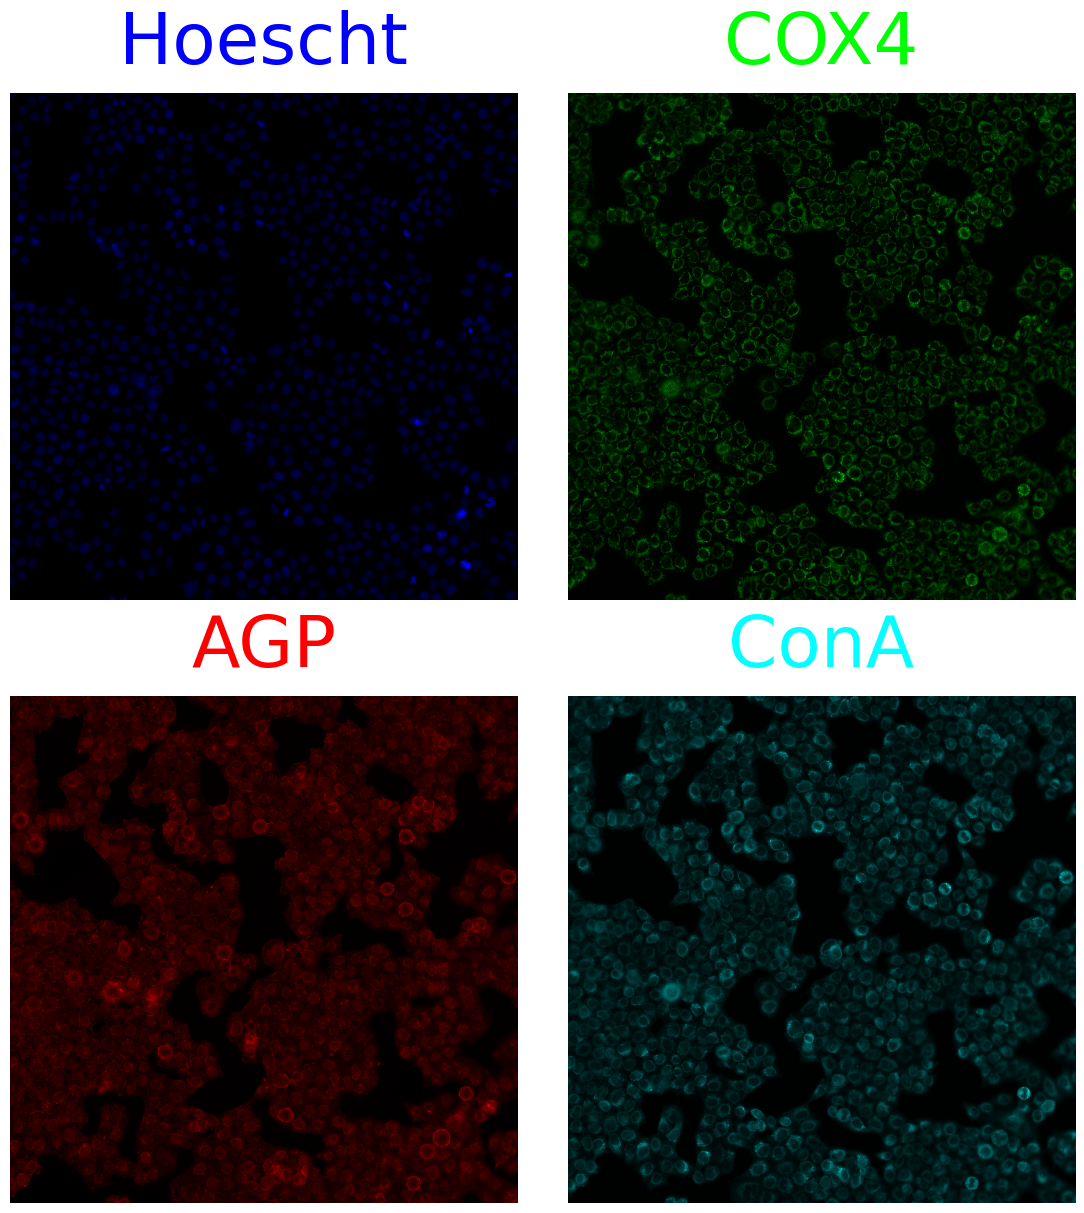

In [4]:
# Load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# Load test image data
print("Loading test image...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
phenotype_test_image_path = str(
    PREPROCESS_FP
    / "images"
    / "phenotype"
    / get_filename(
        {"plate": TEST_PLATE, "well": TEST_WELL, "tile": TEST_TILE},
        "image",
        "tiff",
    )
)
phenotype_test_image = imread(phenotype_test_image_path)

print("Applying illumination correction...")
# Read the illumination correction file
ic_field_path = str(
    PREPROCESS_FP
    / "ic_fields"
    / "phenotype"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "ic_field", "tiff")
)
ic_field = imread(ic_field_path)

# Apply illumination correction
corrected_image = apply_ic_field(phenotype_test_image, correction=ic_field)

# Create and display micropanel of corrected images
print("Example corrected image:")
corrected_microimages = [
    Microimage(
        corrected_image[i], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i]
    )
    for i in range(corrected_image.shape[0])
]
corrected_panel = create_micropanel(corrected_microimages, add_channel_label=True)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Aligning (optional)

- `ALIGN`: Whether to conduct alignment. This is suggested **unless** each image is captured with each channel consecutively. 
- `TARGET`: Name of the channel that other channels will be aligned to.
- `SOURCE`: Name of the channel to align with the target.
- `RIDERS`: Additional channel indices that should follow the same alignment as the source channel.
- `REMOVE_CHANNEL`: Specifies whether to remove channels after alignment. In the case of duplicate channels that are used to align the image, should be set to `source`.
- `UPSAMPLE_FACTOR`: Subpixel alignment precision factor (default: 2). Higher values provide more precise alignment but increase processing time.
- `WINDOW`: Size of the region used for alignment calculation (default: 2). Higher values use a smaller centered region of the image.

### Custom Alignment (optional)

- `CUSTOM_CHANNEL_OFFSETS`: Dict mapping channel names to their (y, x) pixel offsets. Can be used independently or in combination with standard alignment for fine-tuning channel registration. Example: `{"DAPI": (5, 10), "AF750": (3, -2)}` shifts DAPI by 5 pixels up and 10 left, AF750 by 3 up and 2 right. Channel names must match those in `CHANNEL_NAMES`. Offset directions: +y = up, -y = down, +x = left, -x = right.

In [5]:
# Set alignment parameters
ALIGN = None
TARGET = None
SOURCE = None
RIDERS = None
REMOVE_CHANNEL = None
UPSAMPLE_FACTOR = 2
WINDOW = 2

# Set custom channel offsets (use channel names, not indices)
CUSTOM_CHANNEL_OFFSETS = None  # Example: {"DAPI": (5, 10), "AF750": (3, -2)}

# Derive alignment indexes
if ALIGN:
    TARGET_INDEX = CHANNEL_NAMES.index(TARGET)
    SOURCE_INDEX = CHANNEL_NAMES.index(SOURCE)
    RIDER_INDEXES = [CHANNEL_NAMES.index(r) for r in RIDERS]

# Derive custom alignment indexes from channel names
if CUSTOM_CHANNEL_OFFSETS:
    CUSTOM_CHANNEL_OFFSETS_INDEXED = {
        CHANNEL_NAMES.index(name): offset 
        for name, offset in CUSTOM_CHANNEL_OFFSETS.items()
    }

In [6]:
# Start with the corrected image
aligned_image = corrected_image.copy()

# Apply custom offsets 
if CUSTOM_CHANNEL_OFFSETS:
    print(f"Custom offsets: {CUSTOM_CHANNEL_OFFSETS_INDEXED}")
    aligned_image = apply_custom_offsets(
        aligned_image,
        offsets_dict=CUSTOM_CHANNEL_OFFSETS_INDEXED
    )

# Apply automatic alignment
if ALIGN:
    aligned_image = align_phenotype_channels(
        aligned_image,
        target=TARGET_INDEX,
        source=SOURCE_INDEX,
        riders=RIDER_INDEXES,
        remove_channel=REMOVE_CHANNEL,
        upsample_factor=UPSAMPLE_FACTOR,
        window=WINDOW,
        verbose=True,
    )
    # Automatically remove channels based on REMOVE_CHANNEL
    if REMOVE_CHANNEL == "source":
        remove_index = CHANNEL_NAMES.index(SOURCE)
        CHANNEL_NAMES.pop(remove_index)
        CHANNEL_CMAPS.pop(remove_index)
    elif REMOVE_CHANNEL == "target":
        remove_index = CHANNEL_NAMES.index(TARGET)
        CHANNEL_NAMES.pop(remove_index)
        CHANNEL_CMAPS.pop(remove_index)
    elif REMOVE_CHANNEL == "riders":
        # Remove riders in reverse order to maintain correct indices
        for rider in reversed(RIDERS):
            remove_index = CHANNEL_NAMES.index(rider)
            CHANNEL_NAMES.pop(remove_index)
            CHANNEL_CMAPS.pop(remove_index)

### Visualize Alignment Quality (Optional)

Visualize channel alignment across 16 locations in the image. The first channel (DAPI) is shown in grayscale with the remaining 3 channels as an RGB overlay. You may want to consider removing channels for a first pass if you want to visualize alignment between different rounds.

- `VIZ_CHANNELS`: List of exactly 4 channel names to visualize (1st=grayscale base, 2nd-4th=RGB overlay)

In [7]:
# Set channels to visualize (first=grayscale, remaining 3=RGB overlay)
VIZ_CHANNELS = None

if VIZ_CHANNELS is not None:
    print("Visualizing alignment across 16 locations...")
    fig = visualize_phenotype_alignment(
        aligned_image,
        channel_names=CHANNEL_NAMES,
        viz_channels=VIZ_CHANNELS,
        crop_size=300
    )
    plt.show()
else:
    print("Skipping visualization (VIZ_CHANNELS not set)")

Skipping visualization (VIZ_CHANNELS not set)


## <font color='red'>SET PARAMETERS</font>

### Segmentation

**IMPORTANT: GPU Recommendation for CPSAM**
If testing the CPSAM model (`cellpose_model="cpsam"`), we strongly recommend:
- Using a GPU-enabled machine (`GPU=True`)
- Allocating sufficient time (segmentation can take 30+ minutes per tile)
- Consider running this notebook in a GPU-enabled environment or testing on a smaller region

#### Select Segmentation Method
- `SEGMENTATION_METHOD`: Choose from "cellpose" or "stardist" for cell segmentation.

#### Cellpose Parameters (if using "cellpose")
- `CELLPOSE_MODEL`: CellPose model to use. Options: "cyto3" (default), "cyto2", "cyto", or "cpsam" (requires Cellpose 4.x).
- `CELL_FLOW_THRESHOLD` & `NUCLEI_FLOW_THRESHOLD`: Flow threshold for Cellpose segmentation. Default is 0.4.
- `CELL_CELLPROB_THRESHOLD` & `NUCLEI_CELLPROB_THRESHOLD`: Cell probability threshold for Cellpose. Default is 0.
- `HELPER_INDEX`: (Optional) Index of additional channel to help with CPSAM segmentation. Only used with `cellpose_model="cpsam"`. Default is None.
- Note: For Cellpose 3.x models (cyto3, cyto2), nuclei and cell diameters will be estimated automatically. For CPSAM (Cellpose 4.x), diameters can be left as None and will be estimated from initial segmentation results.

#### StarDist Parameters (if using "stardist")
- `STARDIST_MODEL`: StarDist model type. Default is "2D_versatile_fluo".
- `CELL_PROB_THRESHOLD` & `NUCLEI_PROB_THRESHOLD`: Probability threshold for segmentation. Default is 0.479071.
- `CELL_NMS_THRESHOLD` & `NUCLEI_NMS_THRESHOLD`: Non-maximum suppression threshold. Default is 0.3.

In [8]:
# Common parameters
CYTO_CHANNEL = "AGP"
GPU = False
RECONCILE = "contained_in_cells"
DAPI_INDEX = CHANNEL_NAMES.index("Hoescht")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)

# Select segmentation method
SEGMENTATION_METHOD = "cellpose"

if SEGMENTATION_METHOD == "cellpose":
    # Parameters for CellPose method
    CELLPOSE_MODEL = "cyto3"
    NUCLEI_FLOW_THRESHOLD = 0.4
    NUCLEI_CELLPROB_THRESHOLD = 0.0
    CELL_FLOW_THRESHOLD = 1
    CELL_CELLPROB_THRESHOLD = 0
    HELPER_INDEX = None  # Optional: channel index to help with CPSAM segmentation

    # Only estimate diameters for non-CPSAM models
    if CELLPOSE_MODEL != "cpsam":
        from lib.shared.segment_cellpose import estimate_diameters
        print("Estimating optimal cell and nuclei diameters...")
        NUCLEI_DIAMETER, CELL_DIAMETER = estimate_diameters(
            aligned_image,
            dapi_index=DAPI_INDEX,
            cyto_index=CYTO_INDEX,
            cellpose_model=CELLPOSE_MODEL,
        )
    else:
        print("CPSAM model selected. Initial diameters set to None.")
        print("Note: Diameters will be estimated automatically from segmentation results in the next cell.")
        NUCLEI_DIAMETER = None  # Will be estimated from segmentation
        CELL_DIAMETER = None    # Will be estimated from segmentation

elif SEGMENTATION_METHOD == "stardist":
    # Parameters for StarDist method
    STARDIST_MODEL = "2D_versatile_fluo"
    NUCLEI_PROB_THRESHOLD = 0.479071
    NUCLEI_NMS_THRESHOLD = 0.3
    CELL_PROB_THRESHOLD = 0.479071
    CELL_NMS_THRESHOLD = 0.3

/home/matteodibernardo/miniconda3/envs/brieflow_whitney/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Estimating optimal cell and nuclei diameters...
Estimating nuclei diameters...


/home/matteodibernardo/miniconda3/envs/brieflow_whitney/lib/python3.11/site-packages/skimage/util/dtype.py:576: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)
100%|██████████| 3.54k/3.54k [00:00<00:00, 30.7MB/s]


Estimated nuclear diameter: 37.3 pixels
Estimating cell diameters...


100%|██████████| 3.54k/3.54k [00:00<00:00, 22.2MB/s]


Estimated cell diameter: 67.3 pixels


Segmenting image with cellpose...


found 887 nuclei before removing edges
found 879 cells before removing edges
found 825 nuclei before reconciling
found 782 cells before reconciling


removing edges
reconciling masks with method how=contained_in_cells

Nuclei per cell statistics:
--------------------------
Cells with 0 nuclei: 10
Cells with 1 nuclei: 759
Cells with 2 nuclei: 13
--------------------------



found 772 nuclei/cells after reconciling


Number of nuclei segmented: 772
Number of cells segmented: 772
Example microplots for DAPI channel and nuclei segmentation:


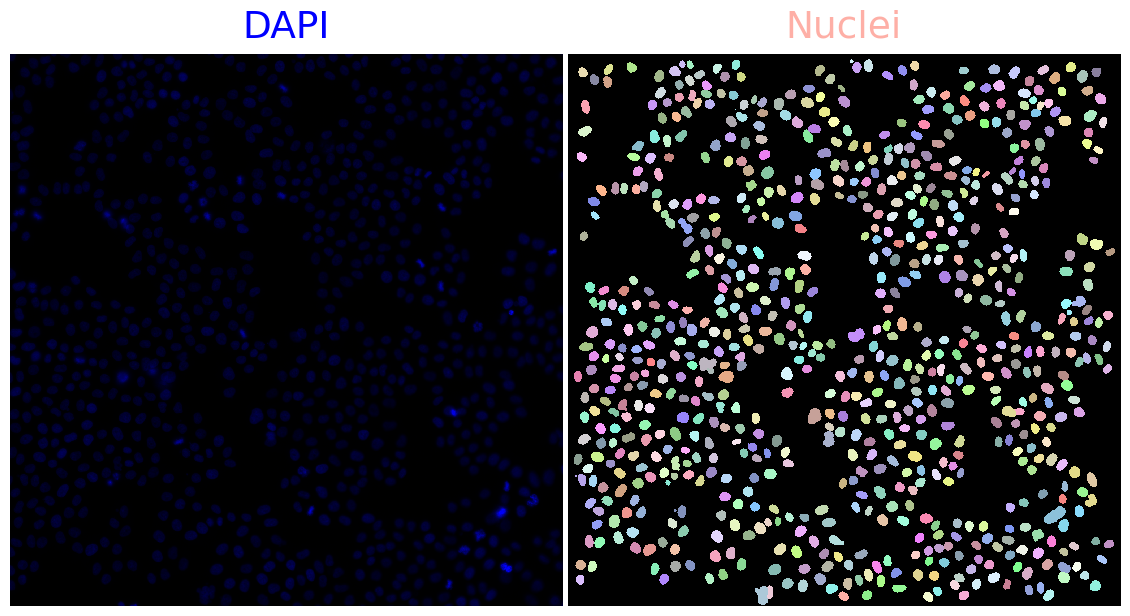

Example microplots for merged channels and cells segmentation:


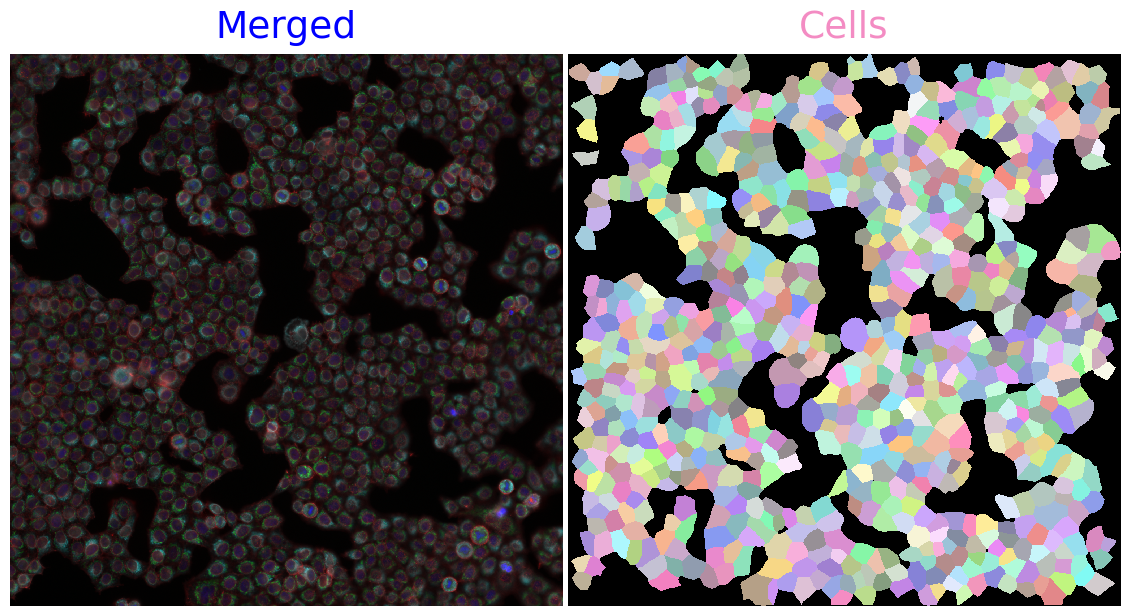

Example microplot for phenotype data annotated with segmentation:


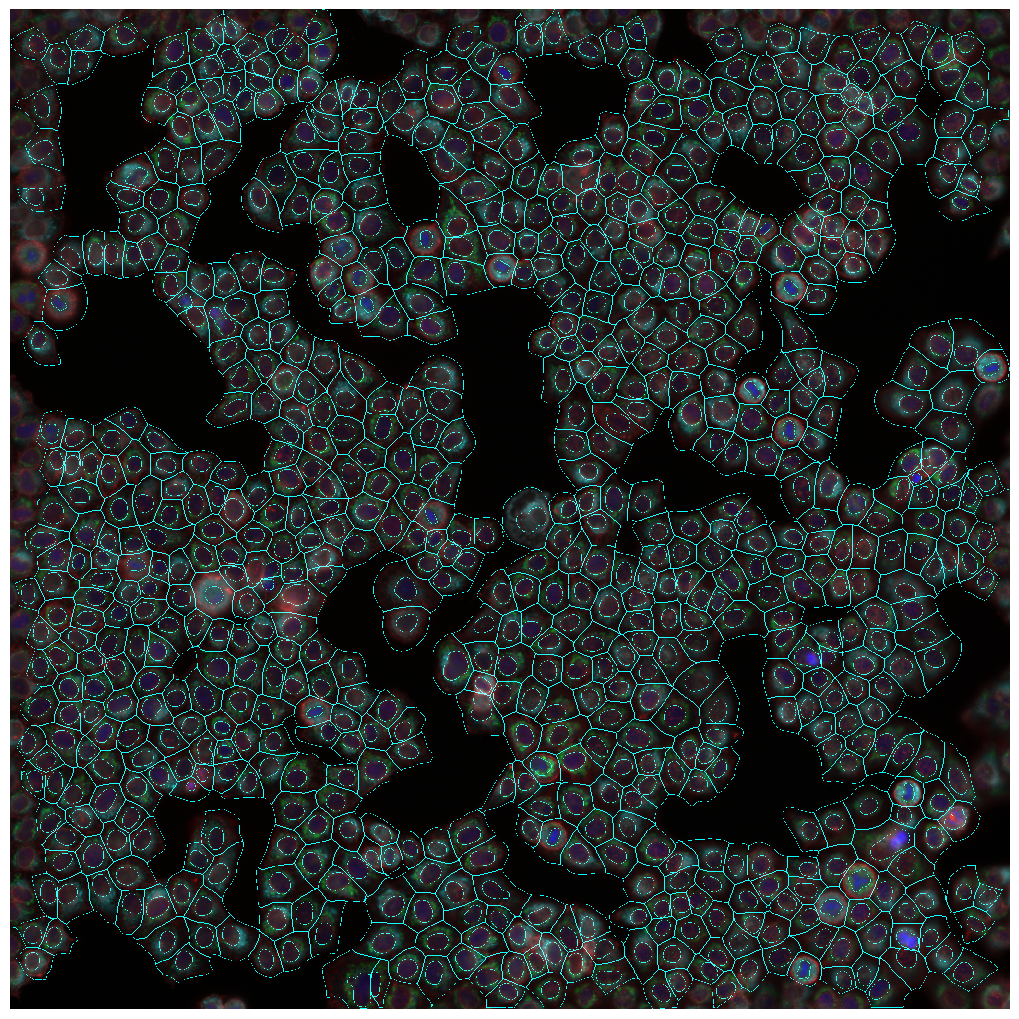

Example microplots for cytoplasms relative to nuclei:
Number of cytoplasms identified: 772


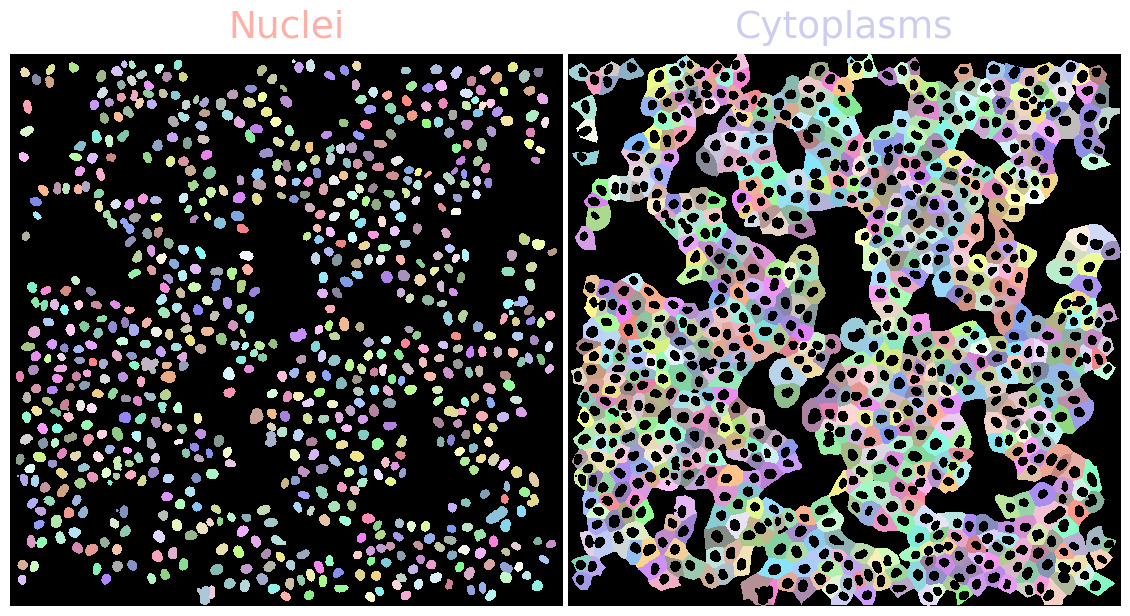

In [9]:
print(f"Segmenting image with {SEGMENTATION_METHOD}...")

if SEGMENTATION_METHOD == "cellpose":
    from lib.shared.segment_cellpose import segment_cellpose
    nuclei, cells = segment_cellpose(
        aligned_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        nuclei_diameter=NUCLEI_DIAMETER,
        cell_diameter=CELL_DIAMETER,
        cellpose_kwargs=dict(
            nuclei_flow_threshold=NUCLEI_FLOW_THRESHOLD,
            nuclei_cellprob_threshold=NUCLEI_CELLPROB_THRESHOLD,
            cell_flow_threshold=CELL_FLOW_THRESHOLD,
            cell_cellprob_threshold=CELL_CELLPROB_THRESHOLD,
        ),
        cellpose_model=CELLPOSE_MODEL,
        helper_index=HELPER_INDEX,
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "stardist":
    from lib.shared.segment_stardist import segment_stardist
    nuclei, cells = segment_stardist(
        aligned_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=STARDIST_MODEL,
        stardist_kwargs=dict(
            nuclei_prob_threshold=NUCLEI_PROB_THRESHOLD,
            nuclei_nms_threshold=NUCLEI_NMS_THRESHOLD,
            cell_prob_threshold=CELL_PROB_THRESHOLD,
            cell_nms_threshold=CELL_NMS_THRESHOLD,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
    )

# Create and display micropanel of nuclei segmentation
print("Example microplots for DAPI channel and nuclei segmentation:")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_seg_microimages = [
    Microimage(
        aligned_image[DAPI_INDEX],
        channel_names="DAPI",
        cmaps=CHANNEL_CMAPS[DAPI_INDEX],
    ),
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
]
nuclei_seg_panel = create_micropanel(nuclei_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of segmented cells
print("Example microplots for merged channels and cells segmentation:")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_seg_microimages = [
    Microimage(
        aligned_image,
        channel_names="Merged",
        cmaps=CHANNEL_CMAPS,
    ),
    Microimage(cells, cmaps=cells_cmap, channel_names="Cells"),
]
cells_seg_panel = create_micropanel(cells_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of annotated phenotype data
print("Example microplot for phenotype data annotated with segmentation:")
annotated_data = image_segmentation_annotations(aligned_image, nuclei, cells)
annotated_microimage = [
    Microimage(
        annotated_data, channel_names="Merged", cmaps=CHANNEL_CMAPS + ["pure_cyan"]
    )
]
annotated_panel = create_micropanel(
    annotated_microimage, num_cols=1, figscaling=10, add_channel_label=False
)
plt.show()

# Create and display micropanel of cytoplasms
print("Example microplots for cytoplasms relative to nuclei:")
cytoplasms = identify_cytoplasm_cellpose(nuclei, cells)
cytoplasms_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasms_microimages = [
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
    Microimage(cytoplasms, cmaps=cytoplasms_cmap, channel_names="Cytoplasms"),
]
cytoplasms_panel = create_micropanel(cytoplasms_microimages, add_channel_label=True)
plt.show()

if SEGMENTATION_METHOD == "cellpose" and CELLPOSE_MODEL == "cpsam":
    from skimage.measure import regionprops
    import numpy as np

    # Calculate nuclei diameters
    nuclei_props = regionprops(nuclei)
    nuclei_diameters = [prop.equivalent_diameter for prop in nuclei_props]
    estimated_nuclei_diameter = np.mean(nuclei_diameters)
    print(f"Nuclei - Average diameter: {estimated_nuclei_diameter:.2f} pixels")

    # Calculate cell diameters  
    cells_props = regionprops(cells)
    cells_diameters = [prop.equivalent_diameter for prop in cells_props]
    estimated_cell_diameter = np.mean(cells_diameters)
    print(f"Cells - Average diameter: {estimated_cell_diameter:.2f} pixels")
    
    # Update the diameter variables for config
    NUCLEI_DIAMETER = estimated_nuclei_diameter
    CELL_DIAMETER = estimated_cell_diameter
    print(f"\nUpdated NUCLEI_DIAMETER to {NUCLEI_DIAMETER:.2f} pixels")
    print(f"Updated CELL_DIAMETER to {CELL_DIAMETER:.2f} pixels")

Note: You may want to adjust these parameters and run segmentation tests if you feel you are capturing too little or too much area for the masks. For cellpose, the nuclei and cell diameters will be automatically estimated, but can be manually adjusted if needed. You manually can set `NUCLEI_DIAMETER` and `CELL_DIAMETER` and rerun the above blocks as many times as needed.

## <font color='red'>SET PARAMETERS</font>

### Feature extraction

- `CP_METHOD`: Methodology for phenotype feature extraction.  
    - `cp_multichannel`: Use emulated code from original _Feldman et. al. 2019_ to extract CellProfiler-like features.
    - `cp_measure`: Use Pythonic version of [CellProfiler](https://github.com/afermg/cp_measure) directly from Imaging Platform. Still in development, may run slowly in Jupyter notebook for testing purposes.
- `FOCI_CHANNEL`: Name of the channel used for foci detection (e.g., "GH2AX", "DAPI"). The channel index will be automatically derived from this name.

In [10]:
CP_METHOD = "cp_multichannel"
FOCI_CHANNEL = None

In [11]:
print("Extracting phenotype features:")

# Compute foci channel index from channel name
if FOCI_CHANNEL:
    FOCI_CHANNEL_INDEX = CHANNEL_NAMES.index(FOCI_CHANNEL)
else:
    FOCI_CHANNEL_INDEX = None

if CP_METHOD == "cp_measure":
    from lib.phenotype.extract_phenotype_cp_measure import extract_phenotype_cp_measure
    # Extract features using cp_measure
    phenotype_cp = extract_phenotype_cp_measure(
        aligned_image,
        nuclei=nuclei,
        cells=cells,
        cytoplasms=cytoplasms,
        channel_names=CHANNEL_NAMES,
    )
else:
    from lib.phenotype.extract_phenotype_cp_multichannel import (
        extract_phenotype_cp_multichannel,
    )
    # Extract features using CellProfiler emulator
    phenotype_cp = extract_phenotype_cp_multichannel(
        aligned_image,
        nuclei=nuclei,
        cells=cells,
        wildcards=WILDCARDS,
        cytoplasms=cytoplasms,
        foci_channel=FOCI_CHANNEL_INDEX,
        channel_names=CHANNEL_NAMES,
    )

phenotype_cp

Extracting phenotype features:


label well  tile    nucleus_i    nucleus_j  nucleus_bounds_0  \
0        1   A2   500    44.240532   632.206755                26   
1        2   A2   500    47.939577  1131.308157                24   
2        3   A2   500    42.375691   430.294659                28   
3        4   A2   500    43.912898   459.638191                28   
4        5   A2   500    30.794702  1068.205298                24   
..     ...  ...   ...          ...          ...               ...   
767    768   A2   500  2028.356989  1391.876344              2010   
768    769   A2   500  2049.796329  1357.580420              2031   
769    770   A2   500  2044.157105  1491.520741              2027   
770    771   A2   500  2043.467306  1126.186574              2025   
771    772   A2   500  2047.058423  1038.189873              2029   

     nucleus_bounds_1  nucleus_bounds_2  nucleus_bounds_3       cell_i  ...  \
0                 617                64               649    38.604379  ...   
1                1114                73              1149    55.713260  ...   
2                 419                58               443    40.156467  ...   
3                 447                60               473    47.310757  ...   
4                1062                39              1076    28.479100  ...   
..                ...               ...               ...          ...  ...   
767              1374              2049              1409  2026.056435  ...   
768              1338              2070              1377  2048.096725  ...   
769              1472              2063              1513  2040.307205  ...   
770              1107              2063              1146  2043.190412  ...   
771              1019              2066              1058  2054.727875  ...   

     cytoplasm_zernike_9_1  cytoplasm_zernike_9_3  cytoplasm_zernike_9_5  \
0                 0.028081               0.036703               0.081285   
1                 0.017131               0.083451               0.034374   
2                 0.086798               0.054470               0.063172   
3                 0.056528               0.139460               0.043443   
4                 0.033412               0.059509               0.043928   
..                     ...                    ...                    ...   
767               0.116528               0.052550               0.026283   
768               0.038231               0.108588               0.020474   
769               0.140280               0.099862               0.017457   
770               0.094833               0.029485               0.046327   
771               0.051412               0.030089               0.067850   

     cytoplasm_zernike_9_7  cytoplasm_zernike_9_9  \
0                 0.058198               0.024443   
1                 0.038318               0.051613   
2                 0.028757               0.063377   
3                 0.033059               0.009715   
4                 0.065563               0.038973   
..                     ...                    ...   
767               0.060554               0.021878   
768               0.057625               0.029518   
769               0.035180               0.045347   
770               0.026312               0.023227   
771               0.006658               0.013893   

     cytoplasm_number_neighbors_1  cytoplasm_percent_touching_1  \
0                               2                      0.280397   
1                               2                      0.197125   
2                               3                      0.452888   
3                               3                      0.432133   
4                               1                      0.225434   
..                            ...                           ...   
767                             3                      0.436090   
768                             3                      0.373134   
769                             3                      0.299320   
770    

In [12]:
# Remove channel names from feature names
def remove_channel_name(feature, channels):
    for channel in channels:
        feature = feature.replace(f"_{channel}", "")
    return feature


# Remove label, well, tile and isolate remaining feature names
filtered_features = [
    feature
    for feature in phenotype_cp.columns.tolist()
    if feature not in ["label", "well", "tile"]
]

# Apply the function to remove channel names
feature_types = [
    remove_channel_name(feature, CHANNEL_NAMES) for feature in filtered_features
]

# Get unique feature types
unique_feature_types = sorted(set(feature_types))

print("Unique feature types:")
unique_feature_types

Unique feature types:


['cell_K',
 'cell_angle_between_neighbors',
 'cell_area',
 'cell_bounds_0',
 'cell_bounds_1',
 'cell_bounds_2',
 'cell_bounds_3',
 'cell_center_mass_c',
 'cell_center_mass_r',
 'cell_centroid_c',
 'cell_centroid_r',
 'cell_compactness',
 'cell_convex_area',
 'cell_correlation',
 'cell_eccentricity',
 'cell_euler_number',
 'cell_extent',
 'cell_first_neighbor_distance',
 'cell_form_factor',
 'cell_frac_at_d_0',
 'cell_frac_at_d_1',
 'cell_frac_at_d_2',
 'cell_frac_at_d_3',
 'cell_haralick_5_0',
 'cell_haralick_5_1',
 'cell_haralick_5_10',
 'cell_haralick_5_11',
 'cell_haralick_5_12',
 'cell_haralick_5_2',
 'cell_haralick_5_3',
 'cell_haralick_5_4',
 'cell_haralick_5_5',
 'cell_haralick_5_6',
 'cell_haralick_5_7',
 'cell_haralick_5_8',
 'cell_haralick_5_9',
 'cell_hu_moments_0',
 'cell_hu_moments_1',
 'cell_hu_moments_2',
 'cell_hu_moments_3',
 'cell_hu_moments_4',
 'cell_hu_moments_5',
 'cell_hu_moments_6',
 'cell_i',
 'cell_int',
 'cell_int_edge',
 'cell_j',
 'cell_lower_quartile',
 'c

## Add phenotype process parameters to config file

In [13]:
# Add phenotype section
config["phenotype"] = {
    "foci_channel_index": FOCI_CHANNEL_INDEX,
    "channel_names": CHANNEL_NAMES,
    "align": ALIGN,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "segmentation_method": SEGMENTATION_METHOD,
    "reconcile": RECONCILE,
    "gpu": GPU,
    "cp_method": CP_METHOD,
}

# Add method-specific parameters based on segmentation method
if SEGMENTATION_METHOD == "cellpose":
    config["phenotype"].update({
        "nuclei_diameter": NUCLEI_DIAMETER,
        "cell_diameter": CELL_DIAMETER,
        "nuclei_flow_threshold": NUCLEI_FLOW_THRESHOLD,
        "nuclei_cellprob_threshold": NUCLEI_CELLPROB_THRESHOLD,
        "cell_flow_threshold": CELL_FLOW_THRESHOLD,
        "cell_cellprob_threshold": CELL_CELLPROB_THRESHOLD,
        "cellpose_model": CELLPOSE_MODEL,
    })
    # Add helper_index only if it's defined
    if HELPER_INDEX is not None:
        config["phenotype"]["helper_index"] = HELPER_INDEX
elif SEGMENTATION_METHOD == "stardist":
    config["phenotype"].update({
        "stardist_model": STARDIST_MODEL,
        "nuclei_prob_threshold": NUCLEI_PROB_THRESHOLD,
        "nuclei_nms_threshold": NUCLEI_NMS_THRESHOLD,
        "cell_prob_threshold": CELL_PROB_THRESHOLD,
        "cell_nms_threshold": CELL_NMS_THRESHOLD,
    })

# Add alignment parameters if defined
if ALIGN:  
    config["phenotype"]["target"] = TARGET_INDEX
    config["phenotype"]["source"] = SOURCE_INDEX
    config["phenotype"]["riders"] = RIDER_INDEXES
    config["phenotype"]["remove_channel"] = REMOVE_CHANNEL
    config["phenotype"]["upsample_factor"] = UPSAMPLE_FACTOR
    config["phenotype"]["window"] = WINDOW

# Add custom channel offsets if defined
if CUSTOM_CHANNEL_OFFSETS:
    config["phenotype"]["custom_channel_offsets"] = CUSTOM_CHANNEL_OFFSETS_INDEXED

# Convert tuples to lists before dumping
safe_config = convert_tuples_to_lists(config)

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(safe_config, config_file, default_flow_style=False, sort_keys=False)